In [1]:
!pwd
import sys
sys.executable

/gpfsx01/home/aaa00162/jupyterhub/notebook/H3-057/work/FocalLoss_check


'/home/bioinfo/.conda/envs/tfgpu_py36/bin/python'

# Focal Loss test


In [2]:
import os, sys
gpu_num = 0
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_num)

# 自作モジュールimport
sys.path.append('/gpfsx01/home/aaa00162/jupyterhub/notebook/H3-057/Submit/make_hERG_PAMPA_model/make_model/')
from modules import *
#sys.path.append('/gpfsx01/home/aaa00162/jupyterhub/notebook/H3-057/Submit/make_hERG_PAMPA_model/make_model/modules/Git/mixup-generator/')
#from random_eraser import get_random_eraser
%reload_ext autoreload
%autoreload 2

import tensorflow as tf
import keras
import keras.backend as K
K.clear_session()
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


## Multi-class binary, categoricalの時のFocal Loss
- https://github.com/umbertogriffo/focal-loss-keras/blob/master/losses.py

In [3]:
import dill

def binary_focal_loss(gamma=2., alpha=.25, mask_value=None):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
     
     # モデルロード時は以下のようにcustom_objectが必要
     import dill
     custom_object = {'binary_focal_loss_fixed': dill.loads(dill.dumps(binary_focal_loss(gamma=2., alpha=.25)))
                      , 'categorical_focal_loss_fixed': dill.loads(dill.dumps(categorical_focal_loss(gamma=2., alpha=.25)))
                      , 'categorical_focal_loss': categorical_focal_loss
                      , 'binary_focal_loss': binary_focal_loss}
      model = keras.models.load_model(input_model_path, custom_objects=custom_object)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        if mask_value is not None:
            mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
            y_true = y_true * mask
            y_pred = y_pred * mask
        
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed


def categorical_focal_loss(gamma=2., alpha=.25, mask_value=None):
    """
    Softmax version of focal loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
     
     # モデルロード時は以下のようにcustom_objectが必要
     import dill
     custom_object = {'binary_focal_loss_fixed': dill.loads(dill.dumps(binary_focal_loss(gamma=2., alpha=.25)))
                      , 'categorical_focal_loss_fixed': dill.loads(dill.dumps(categorical_focal_loss(gamma=2., alpha=.25)))
                      , 'categorical_focal_loss': categorical_focal_loss
                      , 'binary_focal_loss': binary_focal_loss}
      model = keras.models.load_model(input_model_path, custom_objects=custom_object)
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """
        if mask_value is not None:
            mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
            y_true = y_true * mask
            y_pred = y_pred * mask
        
        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Sum the losses in mini_batch
        return K.sum(loss, axis=1)

    return categorical_focal_loss_fixed

## Multi-class classification with focal loss for imbalanced datasets 
- https://github.com/Tony607/Focal_Loss_Keras


- 出力層2nodeの場合

In [4]:
# create data frame containing your data, each column can be accessed # by df['column   name']
dataset = pd.read_csv('./input/PS_20174392719_1491204439457_log.csv')
del dataset['nameDest']
del dataset['nameOrig']
del dataset['type']
display(dataset.head())
print(dataset['isFraud'].value_counts())

def feature_normalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu) / sigma

def init_data():
    #Splitting the Training/Test Data
    from sklearn.model_selection  import train_test_split
    
    X, y = dataset.iloc[:,:-2], dataset.iloc[:, -2]
    y = keras.utils.to_categorical(y, num_classes=2)
    X = feature_normalize(X.as_matrix())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    #print(y_train[:5])
    return X_train, X_test, y_train, y_test

def conf_matrix_jupyter(model, X_test, y_test, LABELS = ['Normal','Fraud']):
    from sklearn import metrics
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set(font_scale=2)
    predictions = model.predict(X_test, batch_size=1000)

    max_test = np.argmax(y_test, axis=1)
    max_predictions = np.argmax(predictions, axis=1)
    confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

    plt.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
    plt.title("Confusion matrix", fontsize=20)
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.show()
    
def binary_classification_train_demo(X_train, X_test, y_train, y_test, activation='sigmoid', loss='binary_crossentropy'):   
    import tensorflow as tf
    from keras.models import Sequential
    from keras.layers import Dense

    K.clear_session()
    model = Sequential()

    input_dim = X_train.shape[1]
    nb_classes = y_train.shape[1]

    model.add(Dense(10, input_dim=input_dim, activation='relu', name='input'))
    model.add(Dense(20, activation='relu', name='fc1'))
    model.add(Dense(10, activation='relu', name='fc2'))
    model.add(Dense(nb_classes, activation=activation, name='output'))

    model.compile(loss=loss, optimizer='nadam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=3, batch_size=1000)

    score = model.evaluate(X_test, y_test, batch_size=1000)
    print(model.metrics_names, score)

    conf_matrix_jupyter(model, X_test, y_test, LABELS = ['Normal','Fraud'])

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0


0    6354407
1       8213
Name: isFraud, dtype: int64


#### sigmoid + Focal Lossなし
- うまくいってる

Epoch 1/3
5090096/5090096 [==============================] - 24s 5us/step - loss: 0.0098 - acc: 0.9989
Epoch 2/3
5090096/5090096 [==============================] - 23s 5us/step - loss: 0.0039 - acc: 0.9993
Epoch 3/3
1272524/1272524 [==============================] - 2s 1us/step
['loss', 'acc'] [0.0032575988104764524, 0.999337150769447]


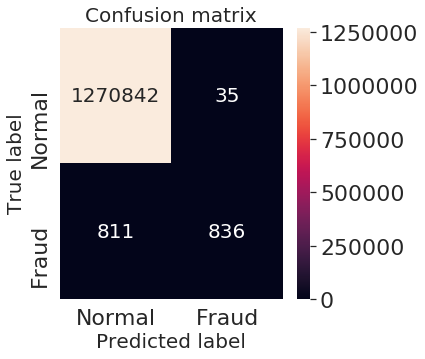

In [5]:
X_train, X_test, y_train, y_test = init_data()
binary_classification_train_demo(X_train, X_test, y_train, y_test, activation='sigmoid', loss='binary_crossentropy')

#### sigmoid + binary_Focal_Lossあり
- うまくいってるが、2nodeだからか全然精度は上がってない（sigmoidだから本来は1nodeでやるべき）

Epoch 1/3
5090096/5090096 [==============================] - 24s 5us/step - loss: 2.6903 - acc: 0.9979
Epoch 2/3
5090096/5090096 [==============================] - 23s 5us/step - loss: 1.0074 - acc: 0.9993
Epoch 3/3
1272524/1272524 [==============================] - 2s 1us/step
['loss', 'acc'] [0.8610878719367148, 0.9993752639069762]


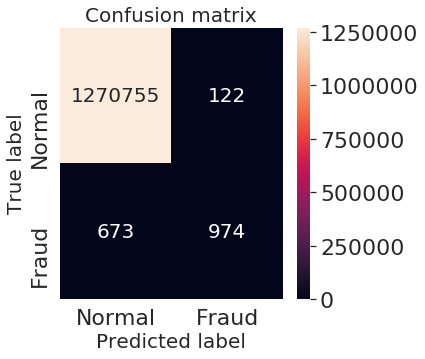

In [6]:
X_train, X_test, y_train, y_test = init_data()
binary_classification_train_demo(X_train, X_test, y_train, y_test, activation='sigmoid', loss=binary_focal_loss(gamma=2., alpha=.25, mask_value=None))

#### sigmoid + 欠損ラベル作成して、maskありでbinary_Focal_Loss使用
- うまくいってる

 1.0    4916815
-1.0     166715
 0.0       6566
Name: 0, dtype: int64
 0.0    5083530
 1.0       6351
-1.0        215
Name: 1, dtype: int64
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Epoch 1/3
5090096/5090096 [==============================] - 24s 5us/step - loss: 2.7719 - acc: 0.9645
Epoch 2/3
5090096/5090096 [==============================] - 23s 5us/step - loss: 1.0466 - acc: 0.9665
Epoch 3/3
1272524/1272524 [==============================] - 2s 1us/step
['loss', 'acc'] [1.0406536880686525, 0.9993540462714668]


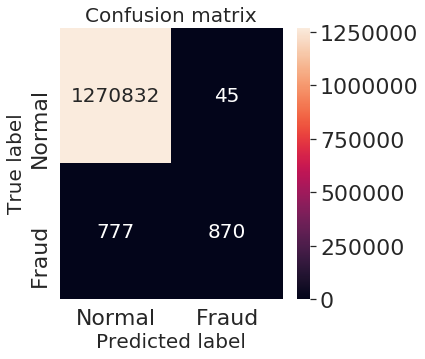

In [7]:
X_train, X_test, y_train, y_test = init_data()

mask_value = -1.0

_df = pd.DataFrame(y_train)
#print(_df.shape)
#display(_df.head())

_df0 = _df[_df[0] == 1.0]
#print(_df0.shape)
_ids = np.random.choice(_df0.index, _df0.shape[0]//30)
#print(_ids[:5])
_df.loc[_ids,0] = mask_value

_df1 = _df[_df[1] == 1.0]
#print(_df1.shape)
_ids = np.random.choice(_df1.index, _df1.shape[0]//30)
#print(_ids[:5])
_df.loc[_ids,1] = mask_value

print(_df[0].value_counts())
print(_df[1].value_counts())

y_train_mask = np.array(_df)
print(y_train_mask)

binary_classification_train_demo(X_train, X_test
                                 , y_train_mask
                                 , y_test
                                 , activation='sigmoid', loss=binary_focal_loss(gamma=2., alpha=.25, mask_value=mask_value))

#### softmax + Focal Lossなし
- うまくいってる

Epoch 1/3
5090096/5090096 [==============================] - 23s 4us/step - loss: 0.0099 - acc: 0.9982
Epoch 2/3
5090096/5090096 [==============================] - 23s 4us/step - loss: 0.0037 - acc: 0.9993
Epoch 3/3
1272524/1272524 [==============================] - 2s 1us/step
['loss', 'acc'] [0.003227625273607976, 0.9993438307666886]


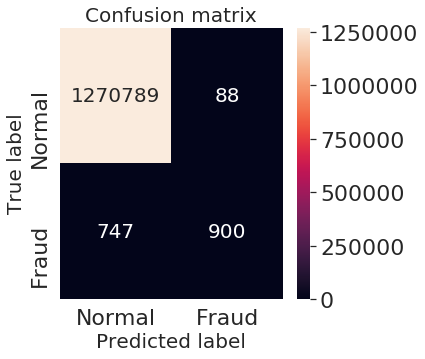

In [8]:
X_train, X_test, y_train, y_test = init_data()
binary_classification_train_demo(X_train, X_test, y_train, y_test, activation='softmax', loss='categorical_crossentropy')

#### softmax + categorical_Focal_Lossあり
- うまくいってて、精度上がってる

Epoch 1/3
5090096/5090096 [==============================] - 24s 5us/step - loss: 0.0011 - acc: 0.9956
Epoch 2/3
5090096/5090096 [==============================] - 24s 5us/step - loss: 2.9174e-04 - acc: 0.9993
Epoch 3/3
1272524/1272524 [==============================] - 2s 1us/step
['loss', 'acc'] [0.00023637541426469033, 0.9993642623851611]


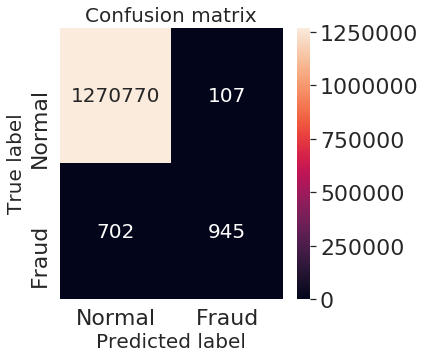

In [9]:
X_train, X_test, y_train, y_test = init_data()
binary_classification_train_demo(X_train, X_test, y_train, y_test, activation='softmax', loss=categorical_focal_loss(gamma=2., alpha=.25, mask_value=None))

#### softmax + 欠損ラベル作成して、maskありでcategorical_Focal_Loss使用
- なんかおかしい。おそらく作った欠損ラベルがおかしい。

 1.0    4916864
-1.0     166666
 0.0       6566
Name: 0, dtype: int64
 0.0    4916864
-1.0     166666
 1.0       6566
Name: 1, dtype: int64
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Epoch 1/3
5090096/5090096 [==============================] - 24s 5us/step - loss: 7.4302e-06 - acc: 0.9987
Epoch 2/3
5090096/5090096 [==============================] - 23s 4us/step - loss: 4.0965e-22 - acc: 0.9987
Epoch 3/3
1272524/1272524 [==============================] - 2s 1us/step
['loss', 'acc'] [4.235164736271502e-22, 0.9987057298387667]


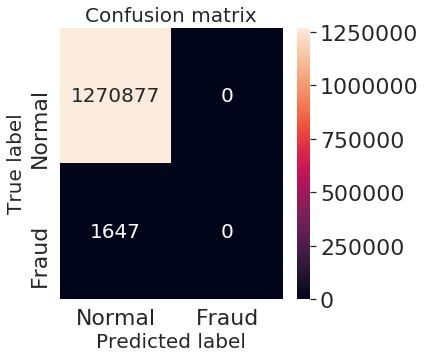

In [10]:
X_train, X_test, y_train, y_test = init_data()

mask_value = -1.0

_df = pd.DataFrame(y_train)
#print(_df.shape)
#display(_df.head())

_df0 = _df[_df[0] == 1.0]
#print(_df0.shape)
_ids = np.random.choice(_df0.index, _df0.shape[0]//30)
#print(_ids[:5])
_df.loc[_ids] = mask_value
#_df.loc[_ids,1] = mask_value

print(_df[0].value_counts())
print(_df[1].value_counts())

y_train_mask = np.array(_df)
print(y_train_mask)

binary_classification_train_demo(X_train, X_test
                                 , y_train_mask
                                 , y_test
                                 , activation='softmax'
                                 , loss=categorical_focal_loss(gamma=2., alpha=.25, mask_value=mask_value))

## 3node learning Demo
- https://www.dlology.com/blog/how-to-multi-task-learning-with-missing-labels-in-keras/


- 出力層3nodeの場合

In [11]:
def multi_learning_demo(activation='sigmoid', loss='binary_crossentropy', mask_value=None):
    """
    https://www.dlology.com/blog/how-to-multi-task-learning-with-missing-labels-in-keras/
    """
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.model_selection  import train_test_split
    import tensorflow as tf
    from keras.models import Sequential
    from keras.layers import Dense
    import numpy as np
    seed = 42
    np.random.seed(seed) # 乱数シード固定
    
    # 2D空間で100,000個のデータポイントをランダムに生成します。各軸の範囲は0〜1
    N =100000
    X = np.random.rand(N,2)
    
    threshold = 0.5
    if isinstance(loss, str) == False:
        # focal loss用に不均衡にする
        threshold = 0.05
    
    # place holder for Y
    Y = np.ones((N,3))
    if activation == 'sigmoid':
        print('sigmoid')
        Y[:,0] = X[:, 1] <= threshold
        Y[:,1] = X[:, 0] >= threshold
        Y[:,2] = X[:, 0] + X[:, 1] > 1
    else:
        print('not sigmoid')
        Y[:,0] = X[:, 1] <= threshold
        Y[:,1] = X[:, 1] > threshold
        Y[:,2] = 0

    # Mask for missing label.
    if mask_value is not None:
        # Drop 2% y0.
        Y[: int(N*0.020), 0] = mask_value
        # Drop 0.7% y1.
        Y[int(N*0.018): int(N*0.025), 1] = mask_value
        # Drop 1.1% y2.
        Y[int(N*0.024): int(N*0.035), 2] = mask_value

    print(Y.shape, Y)
    for i in range(3): 
        print(pd.Series(Y[:,i]).value_counts())
        
    X_train, X_dev, y_train, y_dev = train_test_split(X[:-3000], Y[:-3000], test_size=0.9, random_state=seed)

    K.clear_session()
    model = Sequential()

    input_dim = X_train.shape[1]
    nb_classes = y_train.shape[1]
    print('input_dim, nb_classes:', input_dim, nb_classes)

    model.add(Dense(10, input_dim=input_dim, activation='relu', name='input'))
    model.add(Dense(20, activation='relu', name='fc1'))
    model.add(Dense(10, activation='relu', name='fc2'))
    model.add(Dense(nb_classes, activation=activation, name='output'))

    model.compile(loss=loss, optimizer='nadam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_data=(X_dev,y_dev), epochs=300, batch_size=500000)

    print(model.metrics_names, model.evaluate(X[-3000:],Y[-3000:]))
    
    return model

#### sigmoid + Focal Lossなし
- うまくいってる

In [12]:
model = multi_learning_demo(activation='sigmoid', loss='binary_crossentropy')
x = np.random.rand(1,2)
print(x, model.predict(x))

sigmoid
(100000, 3) [[0. 0. 1.]
 [0. 1. 1.]
 [1. 0. 0.]
 ...
 [0. 0. 0.]
 [1. 1. 0.]
 [1. 1. 0.]]
0.0    50159
1.0    49841
dtype: int64
1.0    50073
0.0    49927
dtype: int64
1.0    50034
0.0    49966
dtype: int64
input_dim, nb_classes: 2 3
Train on 9700 samples, validate on 87300 samples
Epoch 1/300
9700/9700 [==============================] - 0s 16us/step - loss: 0.6875 - acc: 0.4843 - val_loss: 0.6845 - val_acc: 0.5732
Epoch 2/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.6847 - acc: 0.5727 - val_loss: 0.6826 - val_acc: 0.6072
Epoch 3/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.6828 - acc: 0.6048 - val_loss: 0.6810 - val_acc: 0.6315
Epoch 4/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.6812 - acc: 0.6300 - val_loss: 0.6794 - val_acc: 0.6553
Epoch 5/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.6796 - acc: 0.6553 - val_loss: 0.6778 - val_acc: 0.6817
Epoch 6/300
9700/9700 [==========

Epoch 60/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.5127 - acc: 0.8246 - val_loss: 0.5068 - val_acc: 0.8269
Epoch 61/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.5080 - acc: 0.8265 - val_loss: 0.5021 - val_acc: 0.8291
Epoch 62/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.5033 - acc: 0.8285 - val_loss: 0.4973 - val_acc: 0.8312
Epoch 63/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.4986 - acc: 0.8303 - val_loss: 0.4926 - val_acc: 0.8332
Epoch 64/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.4938 - acc: 0.8319 - val_loss: 0.4878 - val_acc: 0.8354
Epoch 65/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.4890 - acc: 0.8339 - val_loss: 0.4830 - val_acc: 0.8376
Epoch 66/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.4842 - acc: 0.8363 - val_loss: 0.4781 - val_acc: 0.8399
Epoch 67/300
9700/9700 [========================

9700/9700 [==============================] - 0s 4us/step - loss: 0.2413 - acc: 0.9492 - val_loss: 0.2377 - val_acc: 0.9505
Epoch 121/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.2379 - acc: 0.9508 - val_loss: 0.2343 - val_acc: 0.9520
Epoch 122/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.2344 - acc: 0.9522 - val_loss: 0.2310 - val_acc: 0.9533
Epoch 123/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.2311 - acc: 0.9534 - val_loss: 0.2277 - val_acc: 0.9547
Epoch 124/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.2277 - acc: 0.9548 - val_loss: 0.2244 - val_acc: 0.9559
Epoch 125/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.2245 - acc: 0.9561 - val_loss: 0.2212 - val_acc: 0.9573
Epoch 126/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.2213 - acc: 0.9574 - val_loss: 0.2181 - val_acc: 0.9586
Epoch 127/300
9700/9700 [==============================

Epoch 180/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.1173 - acc: 0.9834 - val_loss: 0.1164 - val_acc: 0.9841
Epoch 181/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.1163 - acc: 0.9839 - val_loss: 0.1154 - val_acc: 0.9836
Epoch 182/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.1153 - acc: 0.9836 - val_loss: 0.1144 - val_acc: 0.9843
Epoch 183/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.1143 - acc: 0.9838 - val_loss: 0.1134 - val_acc: 0.9839
Epoch 184/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.1133 - acc: 0.9839 - val_loss: 0.1125 - val_acc: 0.9844
Epoch 185/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.1124 - acc: 0.9840 - val_loss: 0.1115 - val_acc: 0.9841
Epoch 186/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.1115 - acc: 0.9837 - val_loss: 0.1106 - val_acc: 0.9847
Epoch 187/300
9700/9700 [================

Epoch 240/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0781 - acc: 0.9871 - val_loss: 0.0775 - val_acc: 0.9887
Epoch 241/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0778 - acc: 0.9886 - val_loss: 0.0772 - val_acc: 0.9872
Epoch 242/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0774 - acc: 0.9869 - val_loss: 0.0769 - val_acc: 0.9886
Epoch 243/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0771 - acc: 0.9882 - val_loss: 0.0766 - val_acc: 0.9868
Epoch 244/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0768 - acc: 0.9866 - val_loss: 0.0762 - val_acc: 0.9884
Epoch 245/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0765 - acc: 0.9880 - val_loss: 0.0759 - val_acc: 0.9864
Epoch 246/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0762 - acc: 0.9866 - val_loss: 0.0756 - val_acc: 0.9882
Epoch 247/300
9700/9700 [================

Epoch 300/300
3000/3000 [==============================] - 0s 28us/step
['loss', 'acc'] [0.061653155783812204, 0.9900000190734863]
[[0.66108923 0.95594316]] [[9.2377581e-07 9.9689376e-01 9.9999928e-01]]


#### sigmoid + binary_Focal_Lossあり
- なんかおかしい。3nodeだからか精度は下がってる（sigmoidだから本来は1nodeでやるべき）

In [13]:
model = multi_learning_demo(activation='sigmoid', loss=[binary_focal_loss(alpha=.25, gamma=2)])
x = np.random.rand(1,2)
print(x, model.predict(x))

sigmoid
(100000, 3) [[0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 0.]
 ...
 [0. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]]
0.0    95031
1.0     4969
dtype: int64
1.0    95109
0.0     4891
dtype: int64
1.0    50034
0.0    49966
dtype: int64
input_dim, nb_classes: 2 3
Train on 9700 samples, validate on 87300 samples
Epoch 1/300
9700/9700 [==============================] - 0s 18us/step - loss: 2312.6033 - acc: 0.2948 - val_loss: 20330.6250 - val_acc: 0.2901
Epoch 2/300
9700/9700 [==============================] - 0s 4us/step - loss: 2264.5198 - acc: 0.2943 - val_loss: 20054.1250 - val_acc: 0.3277
Epoch 3/300
9700/9700 [==============================] - 0s 4us/step - loss: 2233.6787 - acc: 0.3330 - val_loss: 19805.5352 - val_acc: 0.3853
Epoch 4/300
9700/9700 [==============================] - 0s 4us/step - loss: 2205.9724 - acc: 0.3901 - val_loss: 19561.7988 - val_acc: 0.4740
Epoch 5/300
9700/9700 [==============================] - 0s 4us/step - loss: 2178.8105 - acc: 0.4822 - val_loss: 19317.1230 - val_acc: 0.611

Epoch 57/300
9700/9700 [==============================] - 0s 4us/step - loss: 1043.5527 - acc: 0.9061 - val_loss: 9400.4121 - val_acc: 0.9033
Epoch 58/300
9700/9700 [==============================] - 0s 4us/step - loss: 1037.1633 - acc: 0.9061 - val_loss: 9344.0596 - val_acc: 0.9033
Epoch 59/300
9700/9700 [==============================] - 0s 4us/step - loss: 1030.8279 - acc: 0.9061 - val_loss: 9287.9150 - val_acc: 0.9033
Epoch 60/300
9700/9700 [==============================] - 0s 4us/step - loss: 1024.5272 - acc: 0.9061 - val_loss: 9231.7969 - val_acc: 0.9033
Epoch 61/300
9700/9700 [==============================] - 0s 4us/step - loss: 1018.2402 - acc: 0.9061 - val_loss: 9173.0303 - val_acc: 0.9033
Epoch 62/300
9700/9700 [==============================] - 0s 4us/step - loss: 1011.6816 - acc: 0.9061 - val_loss: 9105.9453 - val_acc: 0.9033
Epoch 63/300
9700/9700 [==============================] - 0s 4us/step - loss: 1004.2822 - acc: 0.9061 - val_loss: 9038.7344 - val_acc: 0.9033
Epoch 

Epoch 115/300
9700/9700 [==============================] - 0s 4us/step - loss: 578.2338 - acc: 0.9061 - val_loss: 5199.7646 - val_acc: 0.9033
Epoch 116/300
9700/9700 [==============================] - 0s 4us/step - loss: 572.3882 - acc: 0.9061 - val_loss: 5148.4883 - val_acc: 0.9033
Epoch 117/300
9700/9700 [==============================] - 0s 4us/step - loss: 566.6877 - acc: 0.9061 - val_loss: 5098.4883 - val_acc: 0.9033
Epoch 118/300
9700/9700 [==============================] - 0s 4us/step - loss: 561.1313 - acc: 0.9061 - val_loss: 5049.7725 - val_acc: 0.9033
Epoch 119/300
9700/9700 [==============================] - 0s 4us/step - loss: 555.7156 - acc: 0.9061 - val_loss: 5002.2695 - val_acc: 0.9033
Epoch 120/300
9700/9700 [==============================] - 0s 4us/step - loss: 550.4346 - acc: 0.9061 - val_loss: 4955.9604 - val_acc: 0.9033
Epoch 121/300
9700/9700 [==============================] - 0s 4us/step - loss: 545.2877 - acc: 0.9061 - val_loss: 4910.8320 - val_acc: 0.9033
Epoch 

Epoch 173/300
9700/9700 [==============================] - 0s 4us/step - loss: 382.0285 - acc: 0.9061 - val_loss: 3463.3267 - val_acc: 0.9033
Epoch 174/300
9700/9700 [==============================] - 0s 4us/step - loss: 379.6328 - acc: 0.9061 - val_loss: 3441.0337 - val_acc: 0.9033
Epoch 175/300
9700/9700 [==============================] - 0s 4us/step - loss: 377.1864 - acc: 0.9061 - val_loss: 3415.5034 - val_acc: 0.9033
Epoch 176/300
9700/9700 [==============================] - 0s 4us/step - loss: 374.4609 - acc: 0.9061 - val_loss: 3388.1990 - val_acc: 0.9033
Epoch 177/300
9700/9700 [==============================] - 0s 4us/step - loss: 371.6582 - acc: 0.9061 - val_loss: 3364.6055 - val_acc: 0.9033
Epoch 178/300
9700/9700 [==============================] - 0s 4us/step - loss: 369.0001 - acc: 0.9061 - val_loss: 3340.6445 - val_acc: 0.9033
Epoch 179/300
9700/9700 [==============================] - 0s 4us/step - loss: 366.3766 - acc: 0.9061 - val_loss: 3316.8296 - val_acc: 0.9033
Epoch 

Epoch 231/300
9700/9700 [==============================] - 0s 4us/step - loss: 265.5480 - acc: 0.9053 - val_loss: 2403.4084 - val_acc: 0.9013
Epoch 232/300
9700/9700 [==============================] - 0s 4us/step - loss: 264.1581 - acc: 0.9040 - val_loss: 2390.9238 - val_acc: 0.9021
Epoch 233/300
9700/9700 [==============================] - 0s 4us/step - loss: 262.7814 - acc: 0.9052 - val_loss: 2378.4800 - val_acc: 0.9014
Epoch 234/300
9700/9700 [==============================] - 0s 4us/step - loss: 261.4214 - acc: 0.9041 - val_loss: 2366.2517 - val_acc: 0.9021
Epoch 235/300
9700/9700 [==============================] - 0s 4us/step - loss: 260.0749 - acc: 0.9052 - val_loss: 2354.0623 - val_acc: 0.9014
Epoch 236/300
9700/9700 [==============================] - 0s 4us/step - loss: 258.7404 - acc: 0.9042 - val_loss: 2342.0723 - val_acc: 0.9020
Epoch 237/300
9700/9700 [==============================] - 0s 4us/step - loss: 257.4189 - acc: 0.9052 - val_loss: 2330.1133 - val_acc: 0.9014
Epoch 

Epoch 289/300
9700/9700 [==============================] - 0s 4us/step - loss: 203.8992 - acc: 0.9053 - val_loss: 1847.0797 - val_acc: 0.9017
Epoch 290/300
9700/9700 [==============================] - 0s 4us/step - loss: 203.0859 - acc: 0.9042 - val_loss: 1839.6608 - val_acc: 0.9023
Epoch 291/300
9700/9700 [==============================] - 0s 4us/step - loss: 202.2807 - acc: 0.9051 - val_loss: 1832.4744 - val_acc: 0.9018
Epoch 292/300
9700/9700 [==============================] - 0s 4us/step - loss: 201.4812 - acc: 0.9042 - val_loss: 1825.2067 - val_acc: 0.9024
Epoch 293/300
9700/9700 [==============================] - 0s 4us/step - loss: 200.6924 - acc: 0.9051 - val_loss: 1818.1593 - val_acc: 0.9018
Epoch 294/300
9700/9700 [==============================] - 0s 4us/step - loss: 199.9077 - acc: 0.9043 - val_loss: 1811.0186 - val_acc: 0.9024
Epoch 295/300
9700/9700 [==============================] - 0s 4us/step - loss: 199.1306 - acc: 0.9049 - val_loss: 1804.0830 - val_acc: 0.9018
Epoch 

#### sigmoid +  欠損ラベル作成して、maskありでbinary_Focal_Loss使用
- なんかおかしい。3nodeだからか精度は下がってる（sigmoidだから本来は1nodeでやるべき）

In [14]:
mask_value = -1.0
model = multi_learning_demo(activation='sigmoid', loss=[binary_focal_loss(alpha=.25, gamma=2, mask_value=mask_value)]
                                       , mask_value=mask_value)
x = np.random.rand(1,2)
print(x, model.predict(x))

sigmoid
(100000, 3) [[-1.  1.  1.]
 [-1.  1.  1.]
 [-1.  1.  0.]
 ...
 [ 0.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  1.  0.]]
 0.0    93132
 1.0     4868
-1.0     2000
dtype: int64
 1.0    94440
 0.0     4859
-1.0      701
dtype: int64
 1.0    49495
 0.0    49405
-1.0     1100
dtype: int64
input_dim, nb_classes: 2 3
Train on 9700 samples, validate on 87300 samples
Epoch 1/300
9700/9700 [==============================] - 0s 29us/step - loss: 2276.3164 - acc: 0.2957 - val_loss: 20040.5020 - val_acc: 0.2926
Epoch 2/300
9700/9700 [==============================] - 0s 4us/step - loss: 2229.2932 - acc: 0.2955 - val_loss: 19769.4043 - val_acc: 0.3302
Epoch 3/300
9700/9700 [==============================] - 0s 4us/step - loss: 2199.1218 - acc: 0.3338 - val_loss: 19525.5684 - val_acc: 0.3872
Epoch 4/300
9700/9700 [==============================] - 0s 4us/step - loss: 2172.0049 - acc: 0.3900 - val_loss: 19286.3457 - val_acc: 0.4745
Epoch 5/300
9700/9700 [==============================] - 0s 4us/step - los

Epoch 56/300
9700/9700 [==============================] - 0s 4us/step - loss: 1037.7173 - acc: 0.9003 - val_loss: 9341.2949 - val_acc: 0.8986
Epoch 57/300
9700/9700 [==============================] - 0s 4us/step - loss: 1031.2831 - acc: 0.9003 - val_loss: 9284.7510 - val_acc: 0.8986
Epoch 58/300
9700/9700 [==============================] - 0s 4us/step - loss: 1024.9314 - acc: 0.9003 - val_loss: 9228.6250 - val_acc: 0.8986
Epoch 59/300
9700/9700 [==============================] - 0s 4us/step - loss: 1018.6367 - acc: 0.9003 - val_loss: 9172.7334 - val_acc: 0.8986
Epoch 60/300
9700/9700 [==============================] - 0s 4us/step - loss: 1012.3771 - acc: 0.9003 - val_loss: 9116.8584 - val_acc: 0.8986
Epoch 61/300
9700/9700 [==============================] - 0s 4us/step - loss: 1006.1268 - acc: 0.9003 - val_loss: 9060.8193 - val_acc: 0.8986
Epoch 62/300
9700/9700 [==============================] - 0s 4us/step - loss: 999.8658 - acc: 0.9003 - val_loss: 9001.7607 - val_acc: 0.8986
Epoch 6

Epoch 114/300
9700/9700 [==============================] - 0s 4us/step - loss: 576.7442 - acc: 0.9003 - val_loss: 5180.9365 - val_acc: 0.8986
Epoch 115/300
9700/9700 [==============================] - 0s 4us/step - loss: 570.8092 - acc: 0.9003 - val_loss: 5128.8242 - val_acc: 0.8986
Epoch 116/300
9700/9700 [==============================] - 0s 4us/step - loss: 565.0181 - acc: 0.9003 - val_loss: 5078.0122 - val_acc: 0.8986
Epoch 117/300
9700/9700 [==============================] - 0s 4us/step - loss: 559.3677 - acc: 0.9003 - val_loss: 5028.4810 - val_acc: 0.8986
Epoch 118/300
9700/9700 [==============================] - 0s 4us/step - loss: 553.8604 - acc: 0.9003 - val_loss: 4980.2104 - val_acc: 0.8986
Epoch 119/300
9700/9700 [==============================] - 0s 4us/step - loss: 548.4919 - acc: 0.9003 - val_loss: 4933.1543 - val_acc: 0.8986
Epoch 120/300
9700/9700 [==============================] - 0s 4us/step - loss: 543.2595 - acc: 0.9003 - val_loss: 4887.2930 - val_acc: 0.8986
Epoch 

Epoch 172/300
9700/9700 [==============================] - 0s 4us/step - loss: 378.1401 - acc: 0.9003 - val_loss: 3425.6990 - val_acc: 0.8986
Epoch 173/300
9700/9700 [==============================] - 0s 4us/step - loss: 375.8272 - acc: 0.9003 - val_loss: 3404.3777 - val_acc: 0.8986
Epoch 174/300
9700/9700 [==============================] - 0s 4us/step - loss: 373.4753 - acc: 0.9003 - val_loss: 3382.5549 - val_acc: 0.8986
Epoch 175/300
9700/9700 [==============================] - 0s 4us/step - loss: 371.0813 - acc: 0.9003 - val_loss: 3359.7727 - val_acc: 0.8986
Epoch 176/300
9700/9700 [==============================] - 0s 4us/step - loss: 368.5999 - acc: 0.9003 - val_loss: 3332.5012 - val_acc: 0.8986
Epoch 177/300
9700/9700 [==============================] - 0s 4us/step - loss: 365.7427 - acc: 0.9003 - val_loss: 3307.0464 - val_acc: 0.8986
Epoch 178/300
9700/9700 [==============================] - 0s 4us/step - loss: 363.0203 - acc: 0.9003 - val_loss: 3283.0234 - val_acc: 0.8986
Epoch 

Epoch 230/300
9700/9700 [==============================] - 0s 4us/step - loss: 261.9409 - acc: 0.8971 - val_loss: 2368.4102 - val_acc: 0.8967
Epoch 231/300
9700/9700 [==============================] - 0s 4us/step - loss: 260.5542 - acc: 0.8985 - val_loss: 2355.8530 - val_acc: 0.8957
Epoch 232/300
9700/9700 [==============================] - 0s 4us/step - loss: 259.1880 - acc: 0.8974 - val_loss: 2343.6191 - val_acc: 0.8966
Epoch 233/300
9700/9700 [==============================] - 0s 4us/step - loss: 257.8342 - acc: 0.8982 - val_loss: 2331.3835 - val_acc: 0.8958
Epoch 234/300
9700/9700 [==============================] - 0s 4us/step - loss: 256.4983 - acc: 0.8973 - val_loss: 2319.4202 - val_acc: 0.8965
Epoch 235/300
9700/9700 [==============================] - 0s 4us/step - loss: 255.1753 - acc: 0.8982 - val_loss: 2307.4353 - val_acc: 0.8958
Epoch 236/300
9700/9700 [==============================] - 0s 4us/step - loss: 253.8660 - acc: 0.8975 - val_loss: 2295.6799 - val_acc: 0.8965
Epoch 

Epoch 288/300
9700/9700 [==============================] - 0s 4us/step - loss: 200.8369 - acc: 0.8978 - val_loss: 1817.0092 - val_acc: 0.8971
Epoch 289/300
9700/9700 [==============================] - 0s 4us/step - loss: 200.0310 - acc: 0.8987 - val_loss: 1809.7479 - val_acc: 0.8963
Epoch 290/300
9700/9700 [==============================] - 0s 4us/step - loss: 199.2285 - acc: 0.8978 - val_loss: 1802.5626 - val_acc: 0.8971
Epoch 291/300
9700/9700 [==============================] - 0s 4us/step - loss: 198.4380 - acc: 0.8984 - val_loss: 1795.4595 - val_acc: 0.8963
Epoch 292/300
9700/9700 [==============================] - 0s 4us/step - loss: 197.6521 - acc: 0.8978 - val_loss: 1788.3958 - val_acc: 0.8972
Epoch 293/300
9700/9700 [==============================] - 0s 4us/step - loss: 196.8762 - acc: 0.8982 - val_loss: 1781.4198 - val_acc: 0.8964
Epoch 294/300
9700/9700 [==============================] - 0s 4us/step - loss: 196.1053 - acc: 0.8979 - val_loss: 1774.4648 - val_acc: 0.8972
Epoch 

#### softmax + Focal Lossなし
- うまくいってる

In [15]:
model = multi_learning_demo(activation='softmax', loss='categorical_crossentropy')
x = np.random.rand(1,2)
print(x, model.predict(x))

not sigmoid
(100000, 3) [[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
0.0    50159
1.0    49841
dtype: int64
1.0    50159
0.0    49841
dtype: int64
0.0    100000
dtype: int64
input_dim, nb_classes: 2 3
Train on 9700 samples, validate on 87300 samples
Epoch 1/300
9700/9700 [==============================] - 0s 16us/step - loss: 1.1053 - acc: 0.1644 - val_loss: 1.0882 - val_acc: 0.2577
Epoch 2/300
9700/9700 [==============================] - 0s 4us/step - loss: 1.0888 - acc: 0.2552 - val_loss: 1.0771 - val_acc: 0.4151
Epoch 3/300
9700/9700 [==============================] - 0s 4us/step - loss: 1.0777 - acc: 0.4045 - val_loss: 1.0690 - val_acc: 0.5027
Epoch 4/300
9700/9700 [==============================] - 0s 4us/step - loss: 1.0696 - acc: 0.4952 - val_loss: 1.0603 - val_acc: 0.5027
Epoch 5/300
9700/9700 [==============================] - 0s 4us/step - loss: 1.0609 - acc: 0.4952 - val_loss: 1.0517 - val_acc: 0.5027
Epoch 6/300
9700/9700 [==================

Epoch 60/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.6101 - acc: 0.7368 - val_loss: 0.5998 - val_acc: 0.7485
Epoch 61/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.6037 - acc: 0.7434 - val_loss: 0.5933 - val_acc: 0.7562
Epoch 62/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.5972 - acc: 0.7518 - val_loss: 0.5869 - val_acc: 0.7637
Epoch 63/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.5909 - acc: 0.7594 - val_loss: 0.5805 - val_acc: 0.7707
Epoch 64/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.5845 - acc: 0.7671 - val_loss: 0.5742 - val_acc: 0.7776
Epoch 65/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.5781 - acc: 0.7746 - val_loss: 0.5678 - val_acc: 0.7845
Epoch 66/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.5718 - acc: 0.7820 - val_loss: 0.5615 - val_acc: 0.7915
Epoch 67/300
9700/9700 [========================

9700/9700 [==============================] - 0s 4us/step - loss: 0.2579 - acc: 0.9422 - val_loss: 0.2503 - val_acc: 0.9460
Epoch 121/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.2532 - acc: 0.9439 - val_loss: 0.2456 - val_acc: 0.9471
Epoch 122/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.2485 - acc: 0.9453 - val_loss: 0.2409 - val_acc: 0.9481
Epoch 123/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.2437 - acc: 0.9464 - val_loss: 0.2363 - val_acc: 0.9490
Epoch 124/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.2390 - acc: 0.9472 - val_loss: 0.2316 - val_acc: 0.9503
Epoch 125/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.2342 - acc: 0.9479 - val_loss: 0.2270 - val_acc: 0.9516
Epoch 126/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.2296 - acc: 0.9510 - val_loss: 0.2225 - val_acc: 0.9527
Epoch 127/300
9700/9700 [==============================

Epoch 180/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0911 - acc: 0.9916 - val_loss: 0.0893 - val_acc: 0.9918
Epoch 181/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0899 - acc: 0.9919 - val_loss: 0.0882 - val_acc: 0.9920
Epoch 182/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0887 - acc: 0.9923 - val_loss: 0.0871 - val_acc: 0.9923
Epoch 183/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0876 - acc: 0.9924 - val_loss: 0.0860 - val_acc: 0.9926
Epoch 184/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0865 - acc: 0.9924 - val_loss: 0.0850 - val_acc: 0.9929
Epoch 185/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0855 - acc: 0.9926 - val_loss: 0.0839 - val_acc: 0.9931
Epoch 186/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0844 - acc: 0.9928 - val_loss: 0.0829 - val_acc: 0.9933
Epoch 187/300
9700/9700 [================

Epoch 240/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0508 - acc: 0.9975 - val_loss: 0.0500 - val_acc: 0.9964
Epoch 241/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0504 - acc: 0.9965 - val_loss: 0.0496 - val_acc: 0.9975
Epoch 242/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0501 - acc: 0.9970 - val_loss: 0.0494 - val_acc: 0.9950
Epoch 243/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0498 - acc: 0.9949 - val_loss: 0.0490 - val_acc: 0.9968
Epoch 244/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0496 - acc: 0.9963 - val_loss: 0.0490 - val_acc: 0.9934
Epoch 245/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0493 - acc: 0.9933 - val_loss: 0.0485 - val_acc: 0.9960
Epoch 246/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0491 - acc: 0.9960 - val_loss: 0.0484 - val_acc: 0.9927
Epoch 247/300
9700/9700 [================

Epoch 300/300
3000/3000 [==============================] - 0s 46us/step
['loss', 'acc'] [0.035511267801125845, 0.995]
[[0.66108923 0.95594316]] [[1.0644247e-09 1.0000000e+00 2.6063091e-08]]


#### softmax + categorical_Focal_Lossあり
- うまくいってて、精度上がってる（乱数に依存するので精度下がるときもあり）

In [16]:
model = multi_learning_demo(activation='softmax', loss=[categorical_focal_loss(alpha=.25, gamma=2)])
x = np.random.rand(1,2)
print(x, model.predict(x))

not sigmoid
(100000, 3) [[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
0.0    95031
1.0     4969
dtype: int64
1.0    95031
0.0     4969
dtype: int64
0.0    100000
dtype: int64
input_dim, nb_classes: 2 3
Train on 9700 samples, validate on 87300 samples
Epoch 1/300
9700/9700 [==============================] - 0s 20us/step - loss: 0.1176 - acc: 0.3379 - val_loss: 0.1127 - val_acc: 0.6127
Epoch 2/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.1128 - acc: 0.6162 - val_loss: 0.1095 - val_acc: 0.8901
Epoch 3/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.1095 - acc: 0.8864 - val_loss: 0.1067 - val_acc: 0.9504
Epoch 4/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.1067 - acc: 0.9499 - val_loss: 0.1040 - val_acc: 0.9504
Epoch 5/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.1041 - acc: 0.9499 - val_loss: 0.1013 - val_acc: 0.9504
Epoch 6/300
9700/9700 [==================

Epoch 60/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0155 - acc: 0.9499 - val_loss: 0.0153 - val_acc: 0.9504
Epoch 61/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0154 - acc: 0.9499 - val_loss: 0.0152 - val_acc: 0.9504
Epoch 62/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0153 - acc: 0.9499 - val_loss: 0.0151 - val_acc: 0.9504
Epoch 63/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0152 - acc: 0.9499 - val_loss: 0.0150 - val_acc: 0.9504
Epoch 64/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0151 - acc: 0.9499 - val_loss: 0.0149 - val_acc: 0.9504
Epoch 65/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0150 - acc: 0.9499 - val_loss: 0.0148 - val_acc: 0.9504
Epoch 66/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0149 - acc: 0.9499 - val_loss: 0.0147 - val_acc: 0.9504
Epoch 67/300
9700/9700 [========================

9700/9700 [==============================] - 0s 4us/step - loss: 0.0115 - acc: 0.9499 - val_loss: 0.0114 - val_acc: 0.9504
Epoch 121/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0115 - acc: 0.9499 - val_loss: 0.0113 - val_acc: 0.9504
Epoch 122/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0114 - acc: 0.9499 - val_loss: 0.0113 - val_acc: 0.9504
Epoch 123/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0114 - acc: 0.9499 - val_loss: 0.0112 - val_acc: 0.9504
Epoch 124/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0113 - acc: 0.9499 - val_loss: 0.0112 - val_acc: 0.9504
Epoch 125/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0113 - acc: 0.9499 - val_loss: 0.0111 - val_acc: 0.9504
Epoch 126/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0112 - acc: 0.9499 - val_loss: 0.0111 - val_acc: 0.9504
Epoch 127/300
9700/9700 [==============================

Epoch 180/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0090 - acc: 0.9499 - val_loss: 0.0089 - val_acc: 0.9504
Epoch 181/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0090 - acc: 0.9499 - val_loss: 0.0089 - val_acc: 0.9504
Epoch 182/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0090 - acc: 0.9499 - val_loss: 0.0088 - val_acc: 0.9504
Epoch 183/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0089 - acc: 0.9499 - val_loss: 0.0088 - val_acc: 0.9504
Epoch 184/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0089 - acc: 0.9499 - val_loss: 0.0088 - val_acc: 0.9504
Epoch 185/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0089 - acc: 0.9499 - val_loss: 0.0087 - val_acc: 0.9504
Epoch 186/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0088 - acc: 0.9499 - val_loss: 0.0087 - val_acc: 0.9504
Epoch 187/300
9700/9700 [================

Epoch 240/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0072 - acc: 0.9499 - val_loss: 0.0071 - val_acc: 0.9504
Epoch 241/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0072 - acc: 0.9499 - val_loss: 0.0071 - val_acc: 0.9504
Epoch 242/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0072 - acc: 0.9499 - val_loss: 0.0071 - val_acc: 0.9504
Epoch 243/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0072 - acc: 0.9499 - val_loss: 0.0070 - val_acc: 0.9504
Epoch 244/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0071 - acc: 0.9499 - val_loss: 0.0070 - val_acc: 0.9504
Epoch 245/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0071 - acc: 0.9499 - val_loss: 0.0070 - val_acc: 0.9504
Epoch 246/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0071 - acc: 0.9499 - val_loss: 0.0070 - val_acc: 0.9504
Epoch 247/300
9700/9700 [================

Epoch 300/300
3000/3000 [==============================] - 0s 30us/step
['loss', 'acc'] [0.005920659606034557, 0.9479999998410543]
[[0.66108923 0.95594316]] [[9.2121195e-03 9.9056154e-01 2.2642130e-04]]


#### softmax + 欠損ラベル作成して、maskありでcategorical_Focal_Loss使用
- うまくいってる

In [17]:
mask_value = -1.0
model = multi_learning_demo(activation='softmax', loss=[categorical_focal_loss(alpha=.25, gamma=2, mask_value=mask_value)]
                                       , mask_value=mask_value)
x = np.random.rand(1,2)
print(x, model.predict(x))

not sigmoid
(100000, 3) [[-1.  1.  0.]
 [-1.  1.  0.]
 [-1.  1.  0.]
 ...
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]
 0.0    93132
 1.0     4868
-1.0     2000
dtype: int64
 1.0    94365
 0.0     4934
-1.0      701
dtype: int64
 0.0    98900
-1.0     1100
dtype: int64
input_dim, nb_classes: 2 3
Train on 9700 samples, validate on 87300 samples
Epoch 1/300
9700/9700 [==============================] - 0s 17us/step - loss: 0.1144 - acc: 0.3367 - val_loss: 0.1098 - val_acc: 0.6099
Epoch 2/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.1097 - acc: 0.6125 - val_loss: 0.1066 - val_acc: 0.8847
Epoch 3/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.1065 - acc: 0.8801 - val_loss: 0.1039 - val_acc: 0.9446
Epoch 4/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.1038 - acc: 0.9432 - val_loss: 0.1012 - val_acc: 0.9446
Epoch 5/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.1012 - acc: 0.9432 - val_loss: 0.

Epoch 59/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0153 - acc: 0.9432 - val_loss: 0.0150 - val_acc: 0.9446
Epoch 60/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0152 - acc: 0.9432 - val_loss: 0.0149 - val_acc: 0.9446
Epoch 61/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0151 - acc: 0.9432 - val_loss: 0.0148 - val_acc: 0.9446
Epoch 62/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0150 - acc: 0.9432 - val_loss: 0.0147 - val_acc: 0.9446
Epoch 63/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0149 - acc: 0.9432 - val_loss: 0.0146 - val_acc: 0.9446
Epoch 64/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0148 - acc: 0.9432 - val_loss: 0.0145 - val_acc: 0.9446
Epoch 65/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0147 - acc: 0.9432 - val_loss: 0.0144 - val_acc: 0.9446
Epoch 66/300
9700/9700 [========================

9700/9700 [==============================] - 0s 4us/step - loss: 0.0113 - acc: 0.9432 - val_loss: 0.0111 - val_acc: 0.9446
Epoch 120/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0113 - acc: 0.9432 - val_loss: 0.0110 - val_acc: 0.9446
Epoch 121/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0112 - acc: 0.9432 - val_loss: 0.0110 - val_acc: 0.9446
Epoch 122/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0112 - acc: 0.9432 - val_loss: 0.0109 - val_acc: 0.9446
Epoch 123/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0111 - acc: 0.9432 - val_loss: 0.0109 - val_acc: 0.9446
Epoch 124/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0111 - acc: 0.9432 - val_loss: 0.0108 - val_acc: 0.9446
Epoch 125/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0110 - acc: 0.9432 - val_loss: 0.0108 - val_acc: 0.9446
Epoch 126/300
9700/9700 [==============================

Epoch 179/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0088 - acc: 0.9432 - val_loss: 0.0087 - val_acc: 0.9446
Epoch 180/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0088 - acc: 0.9432 - val_loss: 0.0086 - val_acc: 0.9446
Epoch 181/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0088 - acc: 0.9432 - val_loss: 0.0086 - val_acc: 0.9446
Epoch 182/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0087 - acc: 0.9432 - val_loss: 0.0086 - val_acc: 0.9446
Epoch 183/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0087 - acc: 0.9432 - val_loss: 0.0085 - val_acc: 0.9446
Epoch 184/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0087 - acc: 0.9432 - val_loss: 0.0085 - val_acc: 0.9446
Epoch 185/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0086 - acc: 0.9432 - val_loss: 0.0085 - val_acc: 0.9446
Epoch 186/300
9700/9700 [================

Epoch 239/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0071 - acc: 0.9432 - val_loss: 0.0069 - val_acc: 0.9446
Epoch 240/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0071 - acc: 0.9432 - val_loss: 0.0069 - val_acc: 0.9446
Epoch 241/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0070 - acc: 0.9432 - val_loss: 0.0069 - val_acc: 0.9446
Epoch 242/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0070 - acc: 0.9432 - val_loss: 0.0069 - val_acc: 0.9446
Epoch 243/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0070 - acc: 0.9432 - val_loss: 0.0068 - val_acc: 0.9446
Epoch 244/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0070 - acc: 0.9432 - val_loss: 0.0068 - val_acc: 0.9446
Epoch 245/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0069 - acc: 0.9432 - val_loss: 0.0068 - val_acc: 0.9446
Epoch 246/300
9700/9700 [================

Epoch 299/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0057 - acc: 0.9432 - val_loss: 0.0056 - val_acc: 0.9446
Epoch 300/300
3000/3000 [==============================] - 0s 28us/step
['loss', 'acc'] [0.0059037270365903775, 0.9479999998410543]
[[0.66108923 0.95594316]] [[9.0722470e-03 9.9069792e-01 2.2986531e-04]]


### マルチラベル+cross_entropy_lossの時のFocalLoss

In [18]:
def build_masked_loss(loss_function, mask_value=-1):
    """
    ラベル付けされたデータを「マスクする」損失関数
    https://www.dlology.com/blog/how-to-multi-task-learning-with-missing-labels-in-keras/
    https://github.com/keras-team/keras/issues/3893
    マルチラベル（多クラス多ラベル分類）は sigmoid+binary_crossentropy
    Args:
        loss_func: The loss function to mask（K.binary_crossentropy or K.categorical_crossentropy）
        mask_value: The value to mask in the targets（欠損ラベルとしてマスクする値）
    Returns:
        function: a loss function that acts like loss_function with masked inputs
    """
    def masked_loss_function(y_true, y_pred):
        mask = K.cast(K.not_equal(y_true, mask_value), K.floatx())
        # 欠損の要素が削除される。テンソルのshapeが[batch_size, クラス数+1(欠損クラス)]→[batch_size, クラス数]になる
        return loss_function(y_true * mask, y_pred * mask)
    return masked_loss_function

class FocalLoss_multilabel(object):
    """
    マルチラベル+cross_entropy_lossの時のFocalLoss
    https://github.com/keras-team/keras/issues/10371
    loss関数を引数で渡す様にした

    FocalLossの論文解説記事：
    https://towardsdatascience.com/handling-class-imbalanced-data-using-a-loss-specifically-made-for-it-6e58fd65ffab
    論文ではCIFAR10のクラス不均衡が100倍、200倍の時focal loss有効だった

    Usage:
        f_loss = multi_loss.FocalLoss(loss_function=multi_loss.build_masked_loss(K.binary_crossentropy)).compute_loss
        model.compile(loss=f_loss, optimizer='nadam', metrics=['accuracy', masked_accuracy])
        model.fit_generator(…)
    """
    def __init__(self, gamma=2, alpha=0.25, loss_function=K.binary_crossentropy):
        self._gamma = gamma
        self._alpha = alpha
        self._loss_function = loss_function
        
    def compute_loss(self, y_true, y_pred):
        cross_entropy_loss = self._loss_function(y_true, y_pred)
        p_t = ((y_true * y_pred) + ((1 - y_true) * (1 - y_pred)))
        modulating_factor = 1.0
        if self._gamma:
            modulating_factor = tf.pow(1.0 - p_t, self._gamma)
        alpha_weight_factor = 1.0
        if self._alpha is not None:
            alpha_weight_factor = (y_true * self._alpha + (1 - y_true) * (1 - self._alpha))
        focal_cross_entropy_loss = (modulating_factor * alpha_weight_factor * cross_entropy_loss)

        return K.mean(focal_cross_entropy_loss, axis=-1)

In [19]:
def multi_label_learning_demo(activation='sigmoid', loss=K.binary_crossentropy , mask_value=-1.0, is_FocalLoss_multilabel=True):
    """
    https://www.dlology.com/blog/how-to-multi-task-learning-with-missing-labels-in-keras/
    """
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.model_selection  import train_test_split
    import tensorflow as tf
    from keras.models import Sequential
    from keras.layers import Dense
    import numpy as np
    seed = 42
    np.random.seed(seed) # 乱数シード固定
    
    # 2D空間で100,000個のデータポイントをランダムに生成します。各軸の範囲は0〜1
    N =100000
    X = np.random.rand(N,2)
    
    # focal loss用に不均衡にする
    threshold = 0.05#0.5
    
    # place holder for Y
    Y = np.ones((N,3))
    if activation == 'sigmoid':
        print('sigmoid')
        Y[:,0] = X[:, 1] <= threshold
        Y[:,1] = X[:, 0] >= threshold
        Y[:,2] = X[:, 0] + X[:, 1] > 1
    else:
        print('not sigmoid')
        Y[:,0] = X[:, 1] <= threshold
        Y[:,1] = X[:, 1] > threshold
        Y[:,2] = 0

    # Mask for missing label.
    if mask_value is not None:
        # Drop 2% y0.
        Y[: int(N*0.020), 0] = mask_value
        # Drop 0.7% y1.
        Y[int(N*0.018): int(N*0.025), 1] = mask_value
        # Drop 1.1% y2.
        Y[int(N*0.024): int(N*0.035), 2] = mask_value

    print(Y.shape, Y)
    for i in range(3): 
        print(pd.Series(Y[:,i]).value_counts())
        
    X_train, X_dev, y_train, y_dev = train_test_split(X[:-3000], Y[:-3000], test_size=0.9, random_state=seed)

    K.clear_session()
    model = Sequential()

    input_dim = X_train.shape[1]
    nb_classes = y_train.shape[1]
    print('input_dim, nb_classes:', input_dim, nb_classes)

    model.add(Dense(10, input_dim=input_dim, activation='relu', name='input'))
    model.add(Dense(20, activation='relu', name='fc1'))
    model.add(Dense(10, activation='relu', name='fc2'))
    model.add(Dense(nb_classes, activation=activation, name='output'))

    if mask_value is not None:
        loss = build_masked_loss(loss, mask_value=mask_value)
        
    if is_FocalLoss_multilabel:
        loss = FocalLoss_multilabel(loss_function=loss).compute_loss

    model.compile(loss=loss, optimizer='nadam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_data=(X_dev,y_dev), epochs=300, batch_size=500000)

    print(model.metrics_names, model.evaluate(X[-3000:],Y[-3000:]))
    
    return model

#### sigmoid +  Focal_Lossなし
- うまくいってる

In [20]:
model = multi_label_learning_demo(mask_value=None, is_FocalLoss_multilabel=False)
x = np.random.rand(1,2)
print(x, model.predict(x))

sigmoid
(100000, 3) [[0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 0.]
 ...
 [0. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]]
0.0    95031
1.0     4969
dtype: int64
1.0    95109
0.0     4891
dtype: int64
1.0    50034
0.0    49966
dtype: int64
input_dim, nb_classes: 2 3
Train on 9700 samples, validate on 87300 samples
Epoch 1/300
9700/9700 [==============================] - 0s 16us/step - loss: 0.6779 - acc: 0.2948 - val_loss: 0.6736 - val_acc: 0.3707
Epoch 2/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.6737 - acc: 0.3741 - val_loss: 0.6708 - val_acc: 0.4028
Epoch 3/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.6708 - acc: 0.4062 - val_loss: 0.6682 - val_acc: 0.4320
Epoch 4/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.6682 - acc: 0.4373 - val_loss: 0.6656 - val_acc: 0.4566
Epoch 5/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.6656 - acc: 0.4606 - val_loss: 0.6628 - val_acc: 0.4751
Epoch 6/300
9700/9700 [==========

Epoch 60/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.3321 - acc: 0.9061 - val_loss: 0.3311 - val_acc: 0.9033
Epoch 61/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.3301 - acc: 0.9061 - val_loss: 0.3294 - val_acc: 0.9033
Epoch 62/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.3283 - acc: 0.9061 - val_loss: 0.3278 - val_acc: 0.9033
Epoch 63/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.3267 - acc: 0.9061 - val_loss: 0.3264 - val_acc: 0.9033
Epoch 64/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.3252 - acc: 0.9061 - val_loss: 0.3250 - val_acc: 0.9033
Epoch 65/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.3238 - acc: 0.9061 - val_loss: 0.3238 - val_acc: 0.9033
Epoch 66/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.3226 - acc: 0.9061 - val_loss: 0.3227 - val_acc: 0.9033
Epoch 67/300
9700/9700 [========================

9700/9700 [==============================] - 0s 4us/step - loss: 0.2496 - acc: 0.9061 - val_loss: 0.2492 - val_acc: 0.9033
Epoch 121/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.2474 - acc: 0.9061 - val_loss: 0.2470 - val_acc: 0.9033
Epoch 122/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.2451 - acc: 0.9061 - val_loss: 0.2447 - val_acc: 0.9033
Epoch 123/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.2428 - acc: 0.9061 - val_loss: 0.2424 - val_acc: 0.9033
Epoch 124/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.2405 - acc: 0.9061 - val_loss: 0.2400 - val_acc: 0.9033
Epoch 125/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.2382 - acc: 0.9061 - val_loss: 0.2377 - val_acc: 0.9033
Epoch 126/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.2358 - acc: 0.9061 - val_loss: 0.2353 - val_acc: 0.9033
Epoch 127/300
9700/9700 [==============================

Epoch 180/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.1379 - acc: 0.9061 - val_loss: 0.1386 - val_acc: 0.9033
Epoch 181/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.1368 - acc: 0.9061 - val_loss: 0.1376 - val_acc: 0.9033
Epoch 182/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.1358 - acc: 0.9061 - val_loss: 0.1365 - val_acc: 0.9033
Epoch 183/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.1347 - acc: 0.9061 - val_loss: 0.1355 - val_acc: 0.9033
Epoch 184/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.1337 - acc: 0.9061 - val_loss: 0.1345 - val_acc: 0.9033
Epoch 185/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.1327 - acc: 0.9061 - val_loss: 0.1335 - val_acc: 0.9033
Epoch 186/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.1317 - acc: 0.9061 - val_loss: 0.1325 - val_acc: 0.9033
Epoch 187/300
9700/9700 [================

Epoch 240/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0952 - acc: 0.8694 - val_loss: 0.0960 - val_acc: 0.8663
Epoch 241/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0947 - acc: 0.8688 - val_loss: 0.0955 - val_acc: 0.8657
Epoch 242/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0942 - acc: 0.8681 - val_loss: 0.0951 - val_acc: 0.8651
Epoch 243/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0937 - acc: 0.8671 - val_loss: 0.0946 - val_acc: 0.8644
Epoch 244/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0933 - acc: 0.8662 - val_loss: 0.0941 - val_acc: 0.8639
Epoch 245/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0928 - acc: 0.8656 - val_loss: 0.0937 - val_acc: 0.8631
Epoch 246/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0924 - acc: 0.8649 - val_loss: 0.0932 - val_acc: 0.8627
Epoch 247/300
9700/9700 [================

Epoch 300/300
3000/3000 [==============================] - 0s 27us/step
['loss', 'acc'] [0.0736976805528005, 0.8559999998410542]
[[0.66108923 0.95594316]] [[3.2678074e-07 9.9999118e-01 9.9999392e-01]]


#### sigmoid +  binary_Focal_Loss使用
- うまくいってて、精度上がってる

In [21]:
model = multi_label_learning_demo(mask_value=None)
x = np.random.rand(1,2)
print(x, model.predict(x))

sigmoid
(100000, 3) [[0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 0.]
 ...
 [0. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]]
0.0    95031
1.0     4969
dtype: int64
1.0    95109
0.0     4891
dtype: int64
1.0    50034
0.0    49966
dtype: int64
input_dim, nb_classes: 2 3
Train on 9700 samples, validate on 87300 samples
Epoch 1/300
9700/9700 [==============================] - 0s 17us/step - loss: 0.0795 - acc: 0.2948 - val_loss: 0.0776 - val_acc: 0.2901
Epoch 2/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0778 - acc: 0.2943 - val_loss: 0.0766 - val_acc: 0.3277
Epoch 3/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0768 - acc: 0.3330 - val_loss: 0.0756 - val_acc: 0.3853
Epoch 4/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0758 - acc: 0.3901 - val_loss: 0.0747 - val_acc: 0.4740
Epoch 5/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0749 - acc: 0.4822 - val_loss: 0.0738 - val_acc: 0.6113
Epoch 6/300
9700/9700 [==========

Epoch 60/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0352 - acc: 0.9061 - val_loss: 0.0353 - val_acc: 0.9033
Epoch 61/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0350 - acc: 0.9061 - val_loss: 0.0350 - val_acc: 0.9033
Epoch 62/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0347 - acc: 0.9061 - val_loss: 0.0347 - val_acc: 0.9033
Epoch 63/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0345 - acc: 0.9061 - val_loss: 0.0345 - val_acc: 0.9033
Epoch 64/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0342 - acc: 0.9061 - val_loss: 0.0342 - val_acc: 0.9033
Epoch 65/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0340 - acc: 0.9061 - val_loss: 0.0340 - val_acc: 0.9033
Epoch 66/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0337 - acc: 0.9061 - val_loss: 0.0337 - val_acc: 0.9033
Epoch 67/300
9700/9700 [========================

9700/9700 [==============================] - 0s 4us/step - loss: 0.0195 - acc: 0.9061 - val_loss: 0.0195 - val_acc: 0.9033
Epoch 121/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0193 - acc: 0.9061 - val_loss: 0.0193 - val_acc: 0.9033
Epoch 122/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0191 - acc: 0.9061 - val_loss: 0.0191 - val_acc: 0.9033
Epoch 123/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0189 - acc: 0.9061 - val_loss: 0.0189 - val_acc: 0.9033
Epoch 124/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0187 - acc: 0.9061 - val_loss: 0.0187 - val_acc: 0.9033
Epoch 125/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0185 - acc: 0.9061 - val_loss: 0.0185 - val_acc: 0.9033
Epoch 126/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0183 - acc: 0.9061 - val_loss: 0.0184 - val_acc: 0.9033
Epoch 127/300
9700/9700 [==============================

Epoch 180/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0126 - acc: 0.9061 - val_loss: 0.0127 - val_acc: 0.9033
Epoch 181/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0125 - acc: 0.9061 - val_loss: 0.0126 - val_acc: 0.9033
Epoch 182/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0124 - acc: 0.9061 - val_loss: 0.0125 - val_acc: 0.9033
Epoch 183/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0124 - acc: 0.9061 - val_loss: 0.0124 - val_acc: 0.9033
Epoch 184/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0123 - acc: 0.9061 - val_loss: 0.0123 - val_acc: 0.9033
Epoch 185/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0122 - acc: 0.9061 - val_loss: 0.0123 - val_acc: 0.9033
Epoch 186/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0121 - acc: 0.9061 - val_loss: 0.0122 - val_acc: 0.9033
Epoch 187/300
9700/9700 [================

Epoch 240/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0088 - acc: 0.9038 - val_loss: 0.0088 - val_acc: 0.9030
Epoch 241/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0087 - acc: 0.9057 - val_loss: 0.0088 - val_acc: 0.9000
Epoch 242/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0087 - acc: 0.9027 - val_loss: 0.0088 - val_acc: 0.9031
Epoch 243/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0087 - acc: 0.9059 - val_loss: 0.0087 - val_acc: 0.8995
Epoch 244/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0086 - acc: 0.9020 - val_loss: 0.0087 - val_acc: 0.9032
Epoch 245/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0086 - acc: 0.9059 - val_loss: 0.0087 - val_acc: 0.8991
Epoch 246/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0086 - acc: 0.9014 - val_loss: 0.0086 - val_acc: 0.9033
Epoch 247/300
9700/9700 [================

Epoch 300/300
3000/3000 [==============================] - 0s 30us/step
['loss', 'acc'] [0.00693636466562748, 0.9099999998410543]
[[0.66108923 0.95594316]] [[0.00282203 0.99587554 0.98719585]]


#### sigmoid +  欠損ラベル作成して、maskありでbinary_Focal_Loss使用
- うまくいってる

In [22]:
model = multi_label_learning_demo(mask_value=-1.0)
x = np.random.rand(1,2)
print(x, model.predict(x))

sigmoid
(100000, 3) [[-1.  1.  1.]
 [-1.  1.  1.]
 [-1.  1.  0.]
 ...
 [ 0.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  1.  0.]]
 0.0    93132
 1.0     4868
-1.0     2000
dtype: int64
 1.0    94440
 0.0     4859
-1.0      701
dtype: int64
 1.0    49495
 0.0    49405
-1.0     1100
dtype: int64
input_dim, nb_classes: 2 3
Train on 9700 samples, validate on 87300 samples
Epoch 1/300
9700/9700 [==============================] - 0s 18us/step - loss: 0.0782 - acc: 0.2957 - val_loss: 0.0765 - val_acc: 0.2926
Epoch 2/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0766 - acc: 0.2955 - val_loss: 0.0755 - val_acc: 0.3302
Epoch 3/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0756 - acc: 0.3338 - val_loss: 0.0746 - val_acc: 0.3872
Epoch 4/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0746 - acc: 0.3900 - val_loss: 0.0736 - val_acc: 0.4745
Epoch 5/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0737 - acc: 0.4812 - va

Epoch 59/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0350 - acc: 0.9003 - val_loss: 0.0350 - val_acc: 0.8986
Epoch 60/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0348 - acc: 0.9003 - val_loss: 0.0348 - val_acc: 0.8986
Epoch 61/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0346 - acc: 0.9003 - val_loss: 0.0346 - val_acc: 0.8986
Epoch 62/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0344 - acc: 0.9003 - val_loss: 0.0343 - val_acc: 0.8986
Epoch 63/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0341 - acc: 0.9003 - val_loss: 0.0341 - val_acc: 0.8986
Epoch 64/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0339 - acc: 0.9003 - val_loss: 0.0338 - val_acc: 0.8986
Epoch 65/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0336 - acc: 0.9003 - val_loss: 0.0336 - val_acc: 0.8986
Epoch 66/300
9700/9700 [========================

9700/9700 [==============================] - 0s 4us/step - loss: 0.0193 - acc: 0.9003 - val_loss: 0.0192 - val_acc: 0.8986
Epoch 120/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0191 - acc: 0.9003 - val_loss: 0.0191 - val_acc: 0.8986
Epoch 121/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0189 - acc: 0.9003 - val_loss: 0.0189 - val_acc: 0.8986
Epoch 122/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0187 - acc: 0.9003 - val_loss: 0.0187 - val_acc: 0.8986
Epoch 123/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0185 - acc: 0.9003 - val_loss: 0.0185 - val_acc: 0.8986
Epoch 124/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0184 - acc: 0.9003 - val_loss: 0.0183 - val_acc: 0.8986
Epoch 125/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0182 - acc: 0.9003 - val_loss: 0.0182 - val_acc: 0.8986
Epoch 126/300
9700/9700 [==============================

Epoch 179/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0125 - acc: 0.9003 - val_loss: 0.0126 - val_acc: 0.8986
Epoch 180/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0124 - acc: 0.9003 - val_loss: 0.0125 - val_acc: 0.8986
Epoch 181/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0123 - acc: 0.9003 - val_loss: 0.0124 - val_acc: 0.8986
Epoch 182/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0122 - acc: 0.9003 - val_loss: 0.0123 - val_acc: 0.8986
Epoch 183/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0121 - acc: 0.9003 - val_loss: 0.0122 - val_acc: 0.8986
Epoch 184/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0121 - acc: 0.9003 - val_loss: 0.0121 - val_acc: 0.8986
Epoch 185/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0120 - acc: 0.9003 - val_loss: 0.0120 - val_acc: 0.8986
Epoch 186/300
9700/9700 [================

Epoch 239/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0087 - acc: 0.8995 - val_loss: 0.0087 - val_acc: 0.8932
Epoch 240/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0087 - acc: 0.8943 - val_loss: 0.0087 - val_acc: 0.8979
Epoch 241/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0086 - acc: 0.8996 - val_loss: 0.0087 - val_acc: 0.8930
Epoch 242/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0086 - acc: 0.8940 - val_loss: 0.0086 - val_acc: 0.8979
Epoch 243/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0085 - acc: 0.8996 - val_loss: 0.0086 - val_acc: 0.8931
Epoch 244/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0085 - acc: 0.8941 - val_loss: 0.0085 - val_acc: 0.8979
Epoch 245/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0084 - acc: 0.8996 - val_loss: 0.0085 - val_acc: 0.8935
Epoch 246/300
9700/9700 [================

Epoch 299/300
9700/9700 [==============================] - 0s 4us/step - loss: 0.0067 - acc: 0.8995 - val_loss: 0.0067 - val_acc: 0.8952
Epoch 300/300
3000/3000 [==============================] - 0s 31us/step
['loss', 'acc'] [0.00681511053442955, 0.9089999998410543]
[[0.66108923 0.95594316]] [[0.00273981 0.99583673 0.9878747 ]]


#### softmax +  欠損ラベル作成して、maskありでcategorical_Focal_Loss使用
- エラー

In [23]:
model = multi_label_learning_demo(activation='softmax', loss=K.categorical_crossentropy, mask_value=-1.0)
x = np.random.rand(1,2)
print(x, model.predict(x))

not sigmoid
(100000, 3) [[-1.  1.  0.]
 [-1.  1.  0.]
 [-1.  1.  0.]
 ...
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]
 0.0    93132
 1.0     4868
-1.0     2000
dtype: int64
 1.0    94365
 0.0     4934
-1.0      701
dtype: int64
 0.0    98900
-1.0     1100
dtype: int64
input_dim, nb_classes: 2 3
Train on 9700 samples, validate on 87300 samples
Epoch 1/300


InvalidArgumentError: Incompatible shapes: [9700,3] vs. [9700]
	 [[Node: loss/output_loss/mul_8 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](loss/output_loss/mul_7, loss/output_loss/Neg)]]
	 [[Node: loss/mul/_115 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_927_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'loss/output_loss/mul_8', defined at:
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2869, in _run_cell
    return runner(coro)
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3044, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3209, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-be2ab928269a>", line 1, in <module>
    model = multi_label_learning_demo(activation='softmax', loss=K.categorical_crossentropy, mask_value=-1.0)
  File "<ipython-input-19-ba2e882ff52a>", line 67, in multi_label_learning_demo
    model.compile(loss=loss, optimizer='nadam', metrics=['accuracy'])
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/keras/models.py", line 806, in compile
    **kwargs)
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/keras/engine/training.py", line 860, in compile
    sample_weight, mask)
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/keras/engine/training.py", line 460, in weighted
    score_array = fn(y_true, y_pred)
  File "<ipython-input-18-ecdda528a21e>", line 48, in compute_loss
    focal_cross_entropy_loss = (modulating_factor * alpha_weight_factor * cross_entropy_loss)
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 894, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1117, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2726, in _mul
    "Mul", x=x, y=y, name=name)
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/bioinfo/.conda/envs/tfgpu_py36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Incompatible shapes: [9700,3] vs. [9700]
	 [[Node: loss/output_loss/mul_8 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](loss/output_loss/mul_7, loss/output_loss/Neg)]]
	 [[Node: loss/mul/_115 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_927_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
